In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func,  inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
# Inspect the table Measurement
inspector = inspect(engine)
inspector.get_table_names()
columns = inspector.get_columns('Measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
# Inspect the table Station
inspector = inspect(engine)
inspector.get_table_names()
columns = inspector.get_columns('Station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [104]:
#Explore the database file Measurement
engine.execute('SELECT * FROM Station LIMIT 10').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 (6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 (7, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 (8, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9),
 (9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]

In [12]:
#Explore the database file Measurement
engine.execute('SELECT * FROM Measurement LIMIT 10').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0),
 (6, 'USC00519397', '2010-01-07', 0.06, 70.0),
 (7, 'USC00519397', '2010-01-08', 0.0, 64.0),
 (8, 'USC00519397', '2010-01-09', 0.0, 68.0),
 (9, 'USC00519397', '2010-01-10', 0.0, 73.0),
 (10, 'USC00519397', '2010-01-11', 0.01, 64.0)]

## Calculate Trip Dates

In [176]:
## My Trip dates:  4/7/2018 to 4/21/2018
start_trip = dt.date(2017,4,7)
end_trip   = dt.date(2017,4,21)

# Count the number of days of my Trip
trip_days = session.query(func.count(distinct(Measurement.date))).\
   filter(Measurement.date >= start_trip).filter(Measurement.date <= end_trip).all()
#print(f' My trip was {trip_days[0]} days long')

avg_temp = session.query(func.avg(Measurement.tobs)).\
   filter(Measurement.date >= start_trip).filter(Measurement.date <= end_trip).all()

#print(avg_temp)
print (f' My trip to Hawaii was {trip_days[0]} days long and \n the average temperature was {avg_temp[0]} while I was there')

 My trip to Hawaii was (15,) days long and 
 the average temperature was (73.62105263157895,) while I was there


# Exploratory Climate Analysis

[(19550,)]
('2017-08-23',)
 last date is 2017-08-23
 date 365 days from last is 2016-08-23


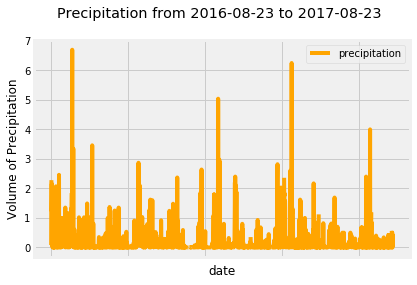

In [73]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Count the number of dates
counts = session.query(func.count(Measurement.date)).all()
print(counts)

#Identify the most recent date in the dbase file
df = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

print(df)
last = pd.Series(df)
last[0]

#Filter the Date by last 365 days from today
precip_today = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > (dt.date.today() - dt.timedelta(days=365))).\
    order_by(Measurement.date).all()

precip_today
#session.query(Measurement.date, Measurement.prcp).all()

# Calculate the date 1 year ago from the last data point in the database
last = dt.date(2017,8,23)
print(f' last date is {last}')
year_ago = last - dt.timedelta(days=365)
print(f' date 365 days from last is {year_ago}')

# Perform a query to retrieve the data and precipitation scores
precip_last = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > (year_ago)).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df_precip = pd.DataFrame(precip_last)
df_precip.rename(columns={'prcp': 'precipitation'}, inplace=True)
df_precip.head()

df_precip.set_index('date', inplace=True)
# Sort the dataframe by date
df_precip.sort_index(inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
df_precip.plot(color='orange')
plt.title(f'Precipitation from {year_ago} to {last} \n')
plt.ylabel('Volume of Precipitation')
plt.savefig(f'Precipitation{year_ago}_{last}.png')


![precipitation](Images/precipitation.png)

In [75]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df_precip.precipitation.describe()

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: precipitation, dtype: float64

![describe](Images/describe.png)

In [125]:
from sqlalchemy import distinct
# Design a query to show how many stations are available in this dataset?
station_counts = session.query(func.count(distinct(Measurement.station))).all()

print(f' There are {station_counts[0]} stations')

 There are (9,) stations


In [107]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
from sqlalchemy import desc
station_freq = session.query( Measurement.station ,func.count(Measurement.station).label('station_count')).group_by(Measurement.station).order_by(desc('station_count')).all()
station_freq

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [124]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?


print('')
station_mean = session.query( Measurement.station ,func.avg(Measurement.tobs)).group_by(Measurement.station).order_by(desc(Measurement.station)).first()
print(f'The mean temperature of the most active station {station_mean[0]} is: {station_mean[1]}')

print('')
highest =  session.query( Measurement.station ,func.max(Measurement.tobs)).order_by(desc(Measurement.tobs)).first()
print(f'The highest temperature of {highest[1]} was recorded from station {highest[0]}')

print('')
lowest =  session.query( Measurement.station ,func.min(Measurement.tobs)).order_by(Measurement.tobs).first()
print(f'The lowest temperation of {lowest[1]} was recorded from station {lowest[0]}')



The mean temperature of the most active station USC00519523 is: 74.5436493068565

The highest temperature of 87.0 was recorded from station USC00519397

The lowest temperation of 53.0 was recorded from station USC00511918


('USC00519281', 2772)


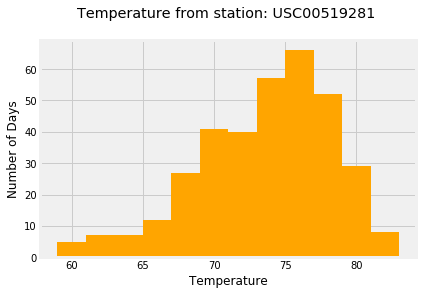

In [154]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

#identify the stattion with the most temperatures
station_temps = session.query( Measurement.station ,func.count(Measurement.tobs).label('temperatures')).group_by(Measurement.station).order_by(desc('temperatures')).all()
print(station_temps[0])

temps = session.query(Measurement.date, Measurement.tobs, Measurement.station).\
    filter(Measurement.date > (year_ago)).filter(Measurement.station == 'USC00519281').order_by(Measurement.date).all()

temps

df_temps = pd.DataFrame(temps)
df_temps.rename(columns={'tobs': 'temperature'}, inplace=True)
df_temps.head()

df_temps.hist(color='orange', bins=12)
plt.title(f'Temperature from station: {df_temps.station[0]} \n')
plt.ylabel('Number of Days')
plt.xlabel('Temperature')
plt.savefig(f'Temperatures_station_{df_temps.station[0]}.png')




![precipitation](Images/station-histogram.png)

In [155]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [178]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

# My trip had start and end date above
print(calc_temps(start_trip - dt.timedelta(days=365), end_trip - dt.timedelta(days=365)))

[(65.0, 73.22340425531915, 80.0)]


In [187]:
trip_temp = calc_temps(start_trip - dt.timedelta(days=365), end_trip - dt.timedelta(days=365))
df_trip= pd.Series(trip_temp)
df_trip

# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


0    (65.0, 73.22340425531915, 80.0)
dtype: object

In [ ]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
